# Titanic Survival Prediction - 5 Models Ensemble (Optimized Parameters)

このノートブックは、事前調整済みの最適なハイパーパラメータを使用して5つのモデルをアンサンブルします。

## 目次
1. セットアップとデータ読み込み
2. 特徴量エンジニアリング
3. 最適なハイパーパラメータ設定
4. Stratified K-Fold学習
5. アンサンブル予測と提出

## 1. セットアップとデータ読み込み

In [1]:
# ライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import string
import pickle
import wandb
from typing import Dict, List, Tuple
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgbm

# TensorFlow/Keras for CNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam

# 定数設定
RANDOM_STATE = 42
N_FOLDS = 5
N_TRIALS = 100  # Optunaの試行回数（より多くのパラメータを探索）
TIMEOUT = 600  # Optunaのタイムアウト（秒）- より長く設定

# wandb設定
WANDB_PROJECT = "titanic-classification"
WANDB_API_KEY = "645b90cb2db844ae6d87767f0e414fac7daf7461"

# 乱数シード固定
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

print("ライブラリのインポート完了")

2025-11-05 01:40:18.901035: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-05 01:40:18.910664: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762306818.920830   41729 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762306818.923889   41729 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-05 01:40:18.934967: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

ライブラリのインポート完了


In [2]:
# データ読み込み
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
print(f"\nTarget distribution:")
print(df_train['Perished'].value_counts(normalize=True))

df_train.head()

Train shape: (891, 12)
Test shape: (418, 11)

Target distribution:
Perished
1    0.616162
0    0.383838
Name: proportion, dtype: float64


,PassengerId,Perished,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,1,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# wandb初期化
import sys
sys.path.append('../notebook')


# wandbにログイン
wandb.login(key="645b90cb2db844ae6d87767f0e414fac7daf7461")

# wandb runを開始
run = wandb.init(
    project=WANDB_PROJECT,
    name="titanic-5model-ensemble",
    config={
        "n_folds": N_FOLDS,
        "n_trials": N_TRIALS,
        "random_state": RANDOM_STATE,
        "models": ["CNN", "RandomForest", "CatBoost", "XGBoost", "LightGBM"],
        "features": X.columns.tolist() if 'X' in dir() else []
    },
    reinit=True
)

print(f"✓ Wandb initialized: {WANDB_PROJECT}")
print(f"  Run name: titanic-5model-ensemble")
print(f"  Dashboard: {run.get_url()}")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /kaggle/working/.netrc
wandb: Currently logged in as: daigokobayashi04 (daigokobayashi04-hal-tokyo) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: ERROR Unable to load kaggle notebook.
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


✓ Wandb initialized: titanic-classification
  Run name: titanic-5model-ensemble
  Dashboard: https://wandb.ai/daigokobayashi04-hal-tokyo/titanic-classification/runs/kltjsrc9


## 2. 特徴量エンジニアリング

In [4]:
def extract_surname(data):
    """名前から姓を抽出"""
    families = []
    
    for i in range(len(data)):
        name = data.iloc[i]
        if '(' in name:
            name_no_bracket = name.split('(')[0]
        else:
            name_no_bracket = name
        
        family = name_no_bracket.split(',')[0]
        
        for c in string.punctuation:
            family = family.replace(c, '').strip()
        
        families.append(family)
    
    return families


def create_features(df_train, df_test):
    """
    特徴量エンジニアリングを実行（データリークなし）
    
    Returns:
        train_df, test_df: 特徴量を追加したDataFrame
    """
    train = df_train.copy()
    test = df_test.copy()
    
    # 全データを結合して特徴量作成
    all_data = pd.concat([train, test], axis=0, sort=False).reset_index(drop=True)
    
    print("特徴量エンジニアリング開始...")
    
    # 1. Title（敬称）抽出
    all_data['Title'] = all_data['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    
    # Titleをグループ化
    all_data['Title'] = all_data['Title'].replace(
        ['Miss', 'Mrs', 'Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms'
    )
    all_data['Title'] = all_data['Title'].replace(
        ['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy'
    )
    
    # 2. 結婚フラグ
    all_data['Is_Married'] = 0
    all_data.loc[all_data['Title'] == 'Mrs', 'Is_Married'] = 1
    
    # 3. Family（姓）
    all_data['Family'] = extract_surname(all_data['Name'])
    
    # 4. Family_Size（家族サイズ）
    all_data['Family_Size'] = all_data['SibSp'] + all_data['Parch'] + 1
    
    # 5. Family_Size_Grouped（家族サイズのビン化）
    family_map = {
        1: 'Alone',
        2: 'Small', 3: 'Small', 4: 'Small',
        5: 'Medium', 6: 'Medium',
        7: 'Large', 8: 'Large', 11: 'Large'
    }
    all_data['Family_Size_Grouped'] = all_data['Family_Size'].map(family_map)
    
    # 6. Ticket_Frequency（チケット頻度）
    all_data['Ticket_Frequency'] = all_data.groupby('Ticket')['Ticket'].transform('count')
    
    # 7. Deck（デッキ）
    all_data['Deck'] = all_data['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
    
    # デッキをグループ化
    all_data['Deck'] = all_data['Deck'].replace(['A', 'B', 'C'], 'ABC')
    all_data['Deck'] = all_data['Deck'].replace(['D', 'E'], 'DE')
    all_data['Deck'] = all_data['Deck'].replace(['F', 'G'], 'FG')
    all_data['Deck'] = all_data['Deck'].replace(['T'], 'M')
    
    # 8. Age補完と離散化
    all_data['Age'] = pd.to_numeric(all_data['Age'], errors='coerce')
    
    # Age を Sex x Pclass の中央値で補完
    age_by_pclass_sex = all_data.groupby(['Sex', 'Pclass'])['Age'].median()
    
    for pclass in [1, 2, 3]:
        for sex in ['male', 'female']:
            mask = (all_data['Age'].isnull()) & (all_data['Pclass'] == pclass) & (all_data['Sex'] == sex)
            all_data.loc[mask, 'Age'] = age_by_pclass_sex.loc[(sex, pclass)]
    
    # Ageをビン化
    all_data['Age_Band'] = pd.cut(all_data['Age'], bins=[0, 12, 18, 30, 50, 80], 
                                    labels=['Child', 'Teen', 'Adult', 'Middle', 'Senior'])
    
    # 9. Fare補完と離散化（訓練データのみから統計量を計算）
    train_idx = ~all_data['Perished'].isna()
    
    # Fare補完: 訓練データの中央値を使用
    train_fare_median = all_data.loc[train_idx, 'Fare'].median()
    all_data['Fare'] = all_data['Fare'].fillna(train_fare_median)
    
    # Fare_Band: 訓練データのみから分位点を計算してビン化
    train_fare_quantiles = all_data.loc[train_idx, 'Fare'].quantile([0.25, 0.5, 0.75]).values
    all_data['Fare_Band'] = pd.cut(
        all_data['Fare'],
        bins=[-np.inf] + train_fare_quantiles.tolist() + [np.inf],
        labels=['Low', 'Medium', 'High', 'Very_High']
    )
    
    # 10. Embarked補完
    all_data['Embarked'] = all_data['Embarked'].fillna('S')
    
    # 11. Sex x Pclass 交互作用
    all_data['Sex_Pclass'] = all_data['Sex'] + '_' + all_data['Pclass'].astype(str)
    
    print(f"  ✓ 特徴量作成完了: {all_data.shape[1]} columns")
    print(f"  ✓ データリーク特徴量(Family_Survival, Ticket_Survival)を削除")
    
    # 訓練データとテストデータに分割
    train_processed = all_data[train_idx].reset_index(drop=True)
    test_processed = all_data[~train_idx].reset_index(drop=True)
    
    return train_processed, test_processed


# 特徴量作成
train_df, test_df = create_features(df_train, df_test)

print(f"\nTrain shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"\nCreated features: {train_df.columns.tolist()}")




特徴量エンジニアリング開始...
  ✓ 特徴量作成完了: 22 columns
  ✓ データリーク特徴量(Family_Survival, Ticket_Survival)を削除

Train shape: (891, 22)
Test shape: (418, 22)

Created features: ['PassengerId', 'Perished', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'Is_Married', 'Family', 'Family_Size', 'Family_Size_Grouped', 'Ticket_Frequency', 'Deck', 'Age_Band', 'Fare_Band', 'Sex_Pclass']


X shape: (891, 10)
y shape: (891,)
X_test shape: (418, 10)

Features: ['Pclass', 'Fare', 'Embarked', 'Title', 'Family_Size_Grouped', 'Ticket_Frequency', 'Deck', 'Age_Band', 'Fare_Band', 'Sex_Pclass']

✓ No data leakage in label encoding (train-only fit)

Categorical features: ['Embarked', 'Title', 'Family_Size_Grouped', 'Deck', 'Age_Band', 'Fare_Band', 'Sex_Pclass']


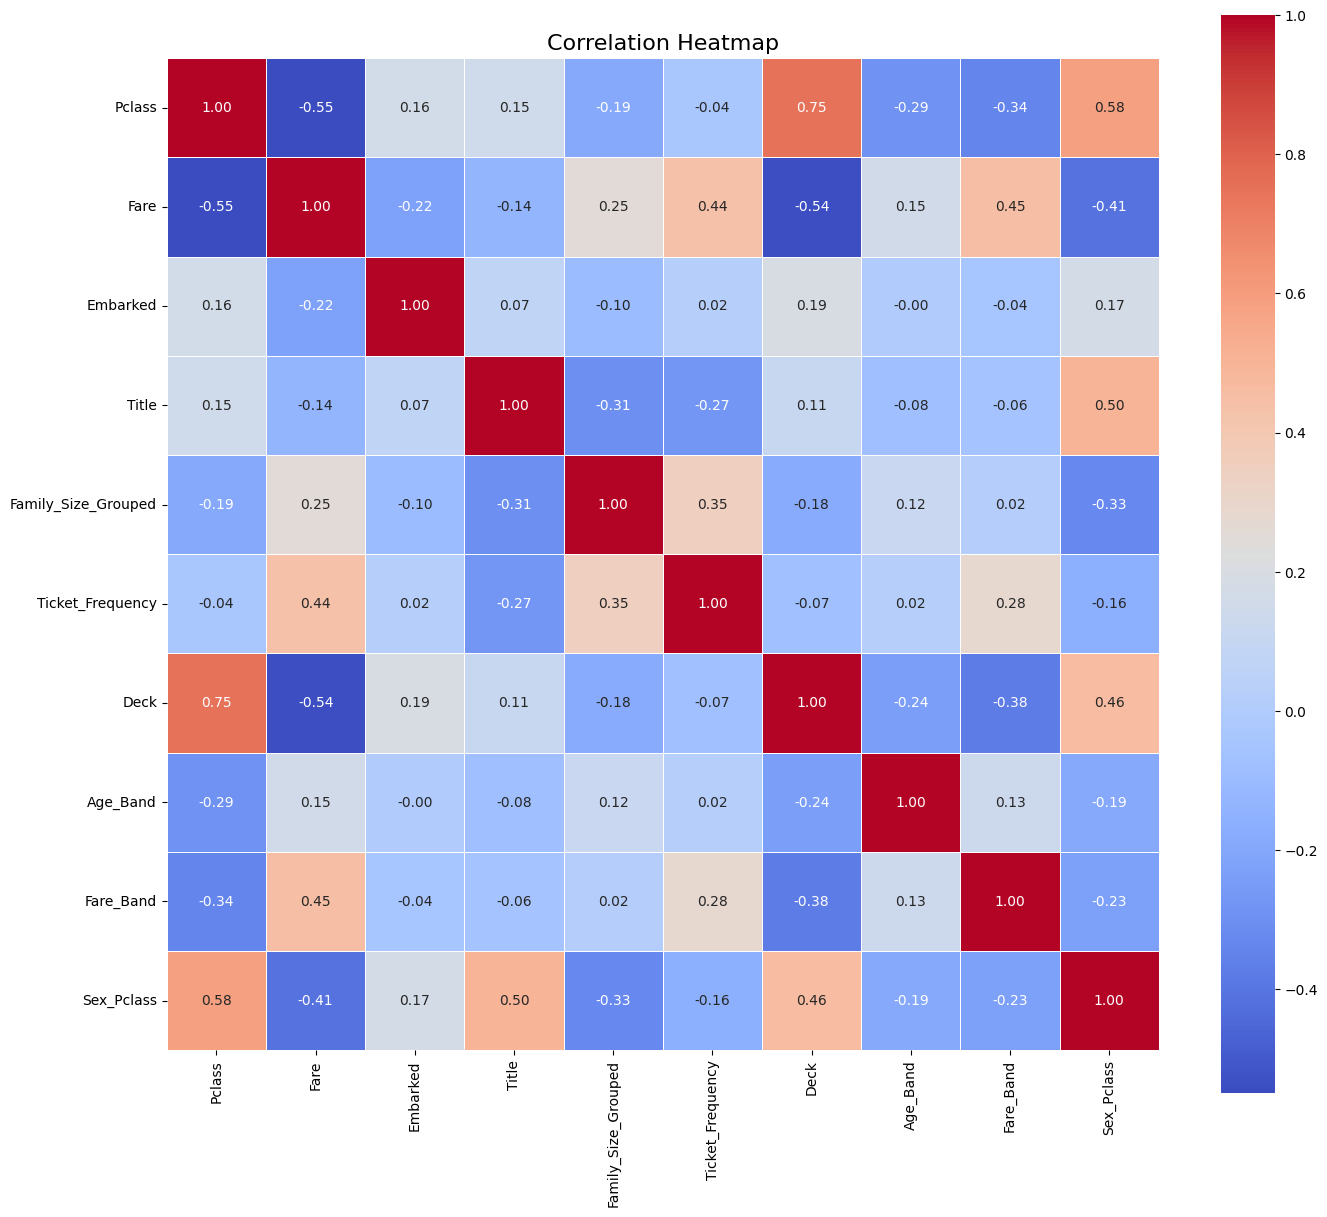

In [5]:
def prepare_data(train_df, test_df):
    """
    データを機械学習モデル用に準備（データリークなし）
    """
    # 使用する特徴量を選択（データリーク特徴量を除外）
    feature_cols = [
        'Pclass',  'Fare',
        'Embarked', 'Title',
        'Family_Size_Grouped', 'Ticket_Frequency', 'Deck',
        'Age_Band', 'Fare_Band', 'Sex_Pclass'
#  'Is_Married',  'Family_Size', 'SibSp', 'Parch','Age', 'Fare'
    ]
    
    train = train_df[feature_cols + ['Perished']].copy()
    test = test_df[feature_cols].copy()
    
    # カテゴリカル変数をエンコード
    cat_features = [ 'Embarked', 'Title', 'Family_Size_Grouped', 'Deck', 'Age_Band', 'Fare_Band', 'Sex_Pclass']
    
    le_dict = {}
    for col in cat_features:
        le = LabelEncoder()
        
        # 訓練データのみでfit（リークを防ぐ）
        le.fit(train[col].astype(str))
        
        # 訓練データを変換
        train[col] = le.transform(train[col].astype(str))
        
        # テストデータを変換（未知のカテゴリは最頻値で置換）
        test_col_str = test[col].astype(str)
        unknown_mask = ~test_col_str.isin(le.classes_)
        
        if unknown_mask.any():
            # 未知のカテゴリがある場合、訓練データの最頻値で置換
            most_frequent = train_df[col].mode()[0]
            test.loc[unknown_mask, col] = most_frequent
            print(f"  Warning: {col} has {unknown_mask.sum()} unknown categories in test, replaced with '{most_frequent}'")
        
        test[col] = le.transform(test[col].astype(str))
        le_dict[col] = le
    
    # 特徴量とターゲットに分割
    X = train.drop('Perished', axis=1)
    y = train['Perished']
    X_test = test
    
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"\nFeatures: {X.columns.tolist()}")
    print(f"\n✓ No data leakage in label encoding (train-only fit)")
    
    return X, y, X_test, cat_features


X, y, X_test, cat_features = prepare_data(train_df, test_df)

print(f"\nCategorical features: {cat_features}")


corr = X.select_dtypes(include='number').corr()

plt.figure(figsize=(16,14))
sns.heatmap(
    corr,
    annot=True,          # ★数値を表示
    fmt=".2f",           # ★小数点2桁
    cmap="coolwarm",
    square=True,
    linewidths=0.5,      # 枠線
    cbar=True            # カラーバー
)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

## 3. 最適なハイパーパラメータ設定（事前調整済み）

In [6]:
# 各モデルの最適なハイパーパラメータを直接設定

# CNN (1D Convolutional Neural Network)
best_params_cnn = {
    'n_conv_layers': 2,
    'filters_1': 128,
    'kernel_size_1': 3,
    'filters_2': 64,
    'kernel_size_2': 3,
    'dropout_conv': 0.3,
    
    'n_dense_layers': 2,
    'dense_units_1': 128,
    'dense_units_2': 64,
    'dropout_dense': 0.4,
    
    'learning_rate': 0.001,
    'batch_size': 32,
    'epochs': 150
}

# RandomForest
best_params_randomforest = {
    'n_estimators': 500,
    'max_depth': 10,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'max_leaf_nodes': 50,
    'bootstrap': True,
    'max_samples': 0.8,
    'criterion': 'gini',
    'min_impurity_decrease': 0.0,
    'class_weight': 'balanced',
    'ccp_alpha': 0.0,
    'random_state': RANDOM_STATE,
    'n_jobs': -1
}

# CatBoost
best_params_catboost = {
    'iterations': 500,
    'learning_rate': 0.05,
    'depth': 6,
    'l2_leaf_reg': 3.0,
    'border_count': 128,
    'random_strength': 1.0,
    'bagging_temperature': 0.5,
    'subsample': 0.8,
    'min_data_in_leaf': 10,
    'max_leaves': 31,
    'leaf_estimation_iterations': 5,
    'random_state': RANDOM_STATE,
    'verbose': 0,
    'task_type': 'CPU'
}

# XGBoost
best_params_xgboost = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 6,
    'min_child_weight': 3,
    'gamma': 0.1,
    'max_delta_step': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'colsample_bylevel': 0.8,
    'colsample_bynode': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'scale_pos_weight': 1.0,
    'max_bin': 256,
    'random_state': RANDOM_STATE,
    'eval_metric': 'logloss',
    'tree_method': 'hist'
}

# LightGBM
best_params_lightgbm = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 6,
    'num_leaves': 31,
    'min_child_samples': 20,
    'min_child_weight': 0.001,
    'min_split_gain': 0.0,
    'subsample': 0.8,
    'subsample_freq': 1,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'max_cat_threshold': 32,
    'cat_smooth': 10.0,
    'max_bin': 255,
    'path_smooth': 0.0,
    'random_state': RANDOM_STATE,
    'verbose': -1,
    'boosting_type': 'gbdt'
}

print("="*60)
print("最適なハイパーパラメータを設定完了")
print("="*60)
print("\nCNN Parameters:")
for k, v in best_params_cnn.items():
    print(f"  {k}: {v}")
    
print("\nRandomForest Parameters:")
for k, v in best_params_randomforest.items():
    print(f"  {k}: {v}")
    
print("\nCatBoost Parameters:")
for k, v in best_params_catboost.items():
    print(f"  {k}: {v}")
    
print("\nXGBoost Parameters:")
for k, v in best_params_xgboost.items():
    print(f"  {k}: {v}")
    
print("\nLightGBM Parameters:")
for k, v in best_params_lightgbm.items():
    print(f"  {k}: {v}")

最適なハイパーパラメータを設定完了

CNN Parameters:
  n_conv_layers: 2
  filters_1: 128
  kernel_size_1: 3
  filters_2: 64
  kernel_size_2: 3
  dropout_conv: 0.3
  n_dense_layers: 2
  dense_units_1: 128
  dense_units_2: 64
  dropout_dense: 0.4
  learning_rate: 0.001
  batch_size: 32
  epochs: 150

RandomForest Parameters:
  n_estimators: 500
  max_depth: 10
  min_samples_split: 5
  min_samples_leaf: 2
  max_features: sqrt
  max_leaf_nodes: 50
  bootstrap: True
  max_samples: 0.8
  criterion: gini
  min_impurity_decrease: 0.0
  class_weight: balanced
  ccp_alpha: 0.0
  random_state: 42
  n_jobs: -1

CatBoost Parameters:
  iterations: 500
  learning_rate: 0.05
  depth: 6
  l2_leaf_reg: 3.0
  border_count: 128
  random_strength: 1.0
  bagging_temperature: 0.5
  subsample: 0.8
  min_data_in_leaf: 10
  max_leaves: 31
  leaf_estimation_iterations: 5
  random_state: 42
  verbose: 0
  task_type: CPU

XGBoost Parameters:
  n_estimators: 500
  learning_rate: 0.05
  max_depth: 6
  min_child_weight: 3
  gamma: 0.1

## 4. Stratified K-Fold学習

In [7]:
def build_cnn_model(params, input_shape):
    """CNNモデルを構築する補助関数"""
    model = models.Sequential()
    
    # Conv層1
    model.add(layers.Conv1D(
        filters=params['filters_1'],
        kernel_size=params['kernel_size_1'],
        activation='relu',
        input_shape=input_shape
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(params['dropout_conv']))
    
    # Conv層2
    if params['n_conv_layers'] >= 2:
        model.add(layers.Conv1D(
            filters=params['filters_2'],
            kernel_size=params['kernel_size_2'],
            activation='relu'
        ))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(params['dropout_conv']))
    
    # Conv層3
    if params['n_conv_layers'] >= 3:
        model.add(layers.Conv1D(
            filters=params['filters_3'],
            kernel_size=params['kernel_size_3'],
            activation='relu'
        ))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(params['dropout_conv']))
    
    model.add(layers.GlobalMaxPooling1D())
    
    # Dense層1
    model.add(layers.Dense(params['dense_units_1'], activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(params['dropout_dense']))
    
    # Dense層2
    if params['n_dense_layers'] >= 2:
        model.add(layers.Dense(params['dense_units_2'], activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(params['dropout_dense']))
    
    # Dense層3
    if params['n_dense_layers'] >= 3:
        model.add(layers.Dense(params['dense_units_3'], activation='relu'))
        model.add(layers.Dropout(params['dropout_dense']))
    
    # 出力層
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # コンパイル
    model.compile(
        optimizer=Adam(learning_rate=params['learning_rate']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [8]:
def train_with_stratified_kfold(X, y, X_test, best_params_cnn, best_params_randomforest, 
                                best_params_catboost, best_params_xgboost, best_params_lightgbm, n_folds=5):
    """
    Stratified K-Foldで複数モデルを学習し、アンサンブル予測を作成
    """
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_STATE)
    
    # OOF予測とテスト予測を保存
    oof_preds_cnn = np.zeros(len(X))
    oof_preds_randomforest = np.zeros(len(X))
    oof_preds_catboost = np.zeros(len(X))
    oof_preds_xgboost = np.zeros(len(X))
    oof_preds_lightgbm = np.zeros(len(X))
    
    test_preds_cnn = np.zeros((len(X_test), n_folds))
    test_preds_randomforest = np.zeros((len(X_test), n_folds))
    test_preds_catboost = np.zeros((len(X_test), n_folds))
    test_preds_xgboost = np.zeros((len(X_test), n_folds))
    test_preds_lightgbm = np.zeros((len(X_test), n_folds))
    
    models_cnn = []
    models_randomforest = []
    models_catboost = []
    models_xgboost = []
    models_lightgbm = []
    scalers = []
    
    # 過学習チェック用のスコア保存
    train_scores = {
        'cnn': [], 'randomforest': [], 'catboost': [], 'xgboost': [], 'lightgbm': []
    }
    valid_scores = {
        'cnn': [], 'randomforest': [], 'catboost': [], 'xgboost': [], 'lightgbm': []
    }
    
    print("="*60)
    print("Stratified K-Fold Training")
    print("="*60)
    
    for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
        print(f"\n{'='*60}")
        print(f"Fold {fold + 1}/{n_folds}")
        print(f"{'='*60}")
        
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        
        # CNN用データ正規化
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_valid_scaled = scaler.transform(X_valid)
        X_test_scaled = scaler.transform(X_test)
        
        X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
        X_valid_cnn = X_valid_scaled.reshape(X_valid_scaled.shape[0], X_valid_scaled.shape[1], 1)
        X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)
        
        scalers.append(scaler)
        
        # CNN
        print("\n[1/5] Training CNN...")
        model_cnn = build_cnn_model(best_params_cnn, (X_train_cnn.shape[1], 1))
        
        early_stop = callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True,
            verbose=0
        )
        
        model_cnn.fit(
            X_train_cnn, y_train,
            validation_data=(X_valid_cnn, y_valid),
            epochs=best_params_cnn['epochs'],
            batch_size=best_params_cnn['batch_size'],
            callbacks=[early_stop],
            verbose=0
        )
        
        # Train & Validation スコア
        train_preds_cnn = (model_cnn.predict(X_train_cnn, verbose=0).flatten() >= 0.5).astype(int)
        valid_preds_cnn = (model_cnn.predict(X_valid_cnn, verbose=0).flatten() >= 0.5).astype(int)
        
        oof_preds_cnn[valid_idx] = valid_preds_cnn
        test_preds_cnn[:, fold] = (model_cnn.predict(X_test_cnn, verbose=0).flatten() >= 0.5).astype(int)
        models_cnn.append(model_cnn)
        
        train_acc_cnn = accuracy_score(y_train, train_preds_cnn)
        valid_acc_cnn = accuracy_score(y_valid, valid_preds_cnn)
        train_scores['cnn'].append(train_acc_cnn)
        valid_scores['cnn'].append(valid_acc_cnn)
        
        print(f"  Train Accuracy: {train_acc_cnn:.4f}")
        print(f"  Valid Accuracy: {valid_acc_cnn:.4f}")
        print(f"  Overfit Gap:    {train_acc_cnn - valid_acc_cnn:.4f}")
        
        # RandomForest
        print("\n[2/5] Training RandomForest...")
        params_rf = best_params_randomforest.copy()
        
        if not params_rf.get('bootstrap', True):
            params_rf.pop('max_samples', None)
        
        model_rf = RandomForestClassifier(**params_rf)
        model_rf.fit(X_train, y_train)
        
        train_preds_rf = model_rf.predict(X_train)
        valid_preds_rf = model_rf.predict(X_valid)
        
        oof_preds_randomforest[valid_idx] = valid_preds_rf
        test_preds_randomforest[:, fold] = model_rf.predict(X_test)
        models_randomforest.append(model_rf)
        
        train_acc_rf = accuracy_score(y_train, train_preds_rf)
        valid_acc_rf = accuracy_score(y_valid, valid_preds_rf)
        train_scores['randomforest'].append(train_acc_rf)
        valid_scores['randomforest'].append(valid_acc_rf)
        
        print(f"  Train Accuracy: {train_acc_rf:.4f}")
        print(f"  Valid Accuracy: {valid_acc_rf:.4f}")
        print(f"  Overfit Gap:    {train_acc_rf - valid_acc_rf:.4f}")
        
        # CatBoost
        print("\n[3/5] Training CatBoost...")
        params_cat = best_params_catboost.copy()
        
        model_cat = CatBoostClassifier(**params_cat)
        model_cat.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=50, verbose=0)
        
        train_preds_cat = model_cat.predict(X_train)
        valid_preds_cat = model_cat.predict(X_valid)
        
        oof_preds_catboost[valid_idx] = valid_preds_cat
        test_preds_catboost[:, fold] = model_cat.predict(X_test)
        models_catboost.append(model_cat)
        
        train_acc_cat = accuracy_score(y_train, train_preds_cat)
        valid_acc_cat = accuracy_score(y_valid, valid_preds_cat)
        train_scores['catboost'].append(train_acc_cat)
        valid_scores['catboost'].append(valid_acc_cat)
        
        print(f"  Train Accuracy: {train_acc_cat:.4f}")
        print(f"  Valid Accuracy: {valid_acc_cat:.4f}")
        print(f"  Overfit Gap:    {train_acc_cat - valid_acc_cat:.4f}")
        
        # XGBoost
        print("\n[4/5] Training XGBoost...")
        params_xgb = best_params_xgboost.copy()
        
        model_xgb = XGBClassifier(**params_xgb)
        model_xgb.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)
        
        train_preds_xgb = model_xgb.predict(X_train)
        valid_preds_xgb = model_xgb.predict(X_valid)
        
        oof_preds_xgboost[valid_idx] = valid_preds_xgb
        test_preds_xgboost[:, fold] = model_xgb.predict(X_test)
        models_xgboost.append(model_xgb)
        
        train_acc_xgb = accuracy_score(y_train, train_preds_xgb)
        valid_acc_xgb = accuracy_score(y_valid, valid_preds_xgb)
        train_scores['xgboost'].append(train_acc_xgb)
        valid_scores['xgboost'].append(valid_acc_xgb)
        
        print(f"  Train Accuracy: {train_acc_xgb:.4f}")
        print(f"  Valid Accuracy: {valid_acc_xgb:.4f}")
        print(f"  Overfit Gap:    {train_acc_xgb - valid_acc_xgb:.4f}")
        
        # LightGBM
        print("\n[5/5] Training LightGBM...")
        params_lgb = best_params_lightgbm.copy()
        
        model_lgb = LGBMClassifier(**params_lgb)
        model_lgb.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
        
        train_preds_lgb = model_lgb.predict(X_train)
        valid_preds_lgb = model_lgb.predict(X_valid)
        
        oof_preds_lightgbm[valid_idx] = valid_preds_lgb
        test_preds_lightgbm[:, fold] = model_lgb.predict(X_test)
        models_lightgbm.append(model_lgb)
        
        train_acc_lgb = accuracy_score(y_train, train_preds_lgb)
        valid_acc_lgb = accuracy_score(y_valid, valid_preds_lgb)
        train_scores['lightgbm'].append(train_acc_lgb)
        valid_scores['lightgbm'].append(valid_acc_lgb)
        
        print(f"  Train Accuracy: {train_acc_lgb:.4f}")
        print(f"  Valid Accuracy: {valid_acc_lgb:.4f}")
        print(f"  Overfit Gap:    {train_acc_lgb - valid_acc_lgb:.4f}")
    
    # OOFスコアとトレーニングスコアの平均を計算
    print(f"\n{'='*60}")
    print("Cross-Validation Results (Mean ± Std)")
    print(f"{'='*60}")
    
    for model_name in ['cnn', 'randomforest', 'catboost', 'xgboost', 'lightgbm']:
        train_mean = np.mean(train_scores[model_name])
        train_std = np.std(train_scores[model_name])
        valid_mean = np.mean(valid_scores[model_name])
        valid_std = np.std(valid_scores[model_name])
        overfit_gap = train_mean - valid_mean
        
        print(f"\n{model_name.upper()}:")
        print(f"  Train Accuracy: {train_mean:.4f} ± {train_std:.4f}")
        print(f"  Valid Accuracy: {valid_mean:.4f} ± {valid_std:.4f}")
        print(f"  Overfit Gap:    {overfit_gap:.4f} {'⚠️ OVERFITTING' if overfit_gap > 0.05 else '✓ Good'}")
    
    print(f"\n{'='*60}")
    print("Out-of-Fold (OOF) Scores")
    print(f"{'='*60}")
    print(f"CNN OOF Accuracy:         {accuracy_score(y, oof_preds_cnn):.4f}")
    print(f"RandomForest OOF Accuracy: {accuracy_score(y, oof_preds_randomforest):.4f}")
    print(f"CatBoost OOF Accuracy:     {accuracy_score(y, oof_preds_catboost):.4f}")
    print(f"XGBoost OOF Accuracy:      {accuracy_score(y, oof_preds_xgboost):.4f}")
    print(f"LightGBM OOF Accuracy:     {accuracy_score(y, oof_preds_lightgbm):.4f}")
    
    # テスト予測を平均化
    test_preds_cnn_avg = test_preds_cnn.mean(axis=1)
    test_preds_randomforest_avg = test_preds_randomforest.mean(axis=1)
    test_preds_catboost_avg = test_preds_catboost.mean(axis=1)
    test_preds_xgboost_avg = test_preds_xgboost.mean(axis=1)
    test_preds_lightgbm_avg = test_preds_lightgbm.mean(axis=1)
    
    return {
        'oof_cnn': oof_preds_cnn,
        'oof_randomforest': oof_preds_randomforest,
        'oof_catboost': oof_preds_catboost,
        'oof_xgboost': oof_preds_xgboost,
        'oof_lightgbm': oof_preds_lightgbm,
        'test_cnn': test_preds_cnn_avg,
        'test_randomforest': test_preds_randomforest_avg,
        'test_catboost': test_preds_catboost_avg,
        'test_xgboost': test_preds_xgboost_avg,
        'test_lightgbm': test_preds_lightgbm_avg,
        'models_cnn': models_cnn,
        'models_randomforest': models_randomforest,
        'models_catboost': models_catboost,
        'models_xgboost': models_xgboost,
        'models_lightgbm': models_lightgbm,
        'scalers': scalers,
        'train_scores': train_scores,
        'valid_scores': valid_scores
    }


# K-Fold学習実行
results = train_with_stratified_kfold(
    X, y, X_test,
    best_params_cnn,
    best_params_randomforest,
    best_params_catboost,
    best_params_xgboost,
    best_params_lightgbm,
    n_folds=N_FOLDS
)

Stratified K-Fold Training

Fold 1/5

[1/5] Training CNN...


2025-11-05 01:40:32.218149: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1762306832.218221   41729 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9502 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1762306835.138296   41892 service.cc:148] XLA service 0x7ddecc018d80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762306835.138330   41892 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2025-11-05 01:40:35.175675: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1762306835.370145   41892 cuda_dnn.cc:529] Loa

  Train Accuracy: 0.8385
  Valid Accuracy: 0.8492
  Overfit Gap:    -0.0107

[2/5] Training RandomForest...
  Train Accuracy: 0.8961
  Valid Accuracy: 0.8547
  Overfit Gap:    0.0413

[3/5] Training CatBoost...
  Train Accuracy: 0.8975
  Valid Accuracy: 0.8547
  Overfit Gap:    0.0427

[4/5] Training XGBoost...
  Train Accuracy: 0.9059
  Valid Accuracy: 0.8492
  Overfit Gap:    0.0567

[5/5] Training LightGBM...
  Train Accuracy: 0.9213
  Valid Accuracy: 0.8380
  Overfit Gap:    0.0834

Fold 2/5

[1/5] Training CNN...
  Train Accuracy: 0.8569
  Valid Accuracy: 0.8146
  Overfit Gap:    0.0423

[2/5] Training RandomForest...
  Train Accuracy: 0.9004
  Valid Accuracy: 0.8596
  Overfit Gap:    0.0409

[3/5] Training CatBoost...
  Train Accuracy: 0.8920
  Valid Accuracy: 0.8258
  Overfit Gap:    0.0662

[4/5] Training XGBoost...
  Train Accuracy: 0.9060
  Valid Accuracy: 0.8539
  Overfit Gap:    0.0521

[5/5] Training LightGBM...
  Train Accuracy: 0.9215
  Valid Accuracy: 0.8371
  Overfit G

## 5. アンサンブル予測と提出

In [9]:
# 異なるアンサンブル戦略の比較

print("="*60)
print("Different Ensemble Strategies Comparison")
print("="*60)

# 1. 全5モデル平均（多数決）
ensemble_5models = (
    results['oof_cnn'] +
    results['oof_randomforest'] +
    results['oof_catboost'] +
    results['oof_xgboost'] +
    results['oof_lightgbm']
) / 5
score_5models = accuracy_score(y, (ensemble_5models >= 0.5).astype(int))

# 2. Tree-based 4モデルのみ（CNNを除外）
ensemble_4models = (
    results['oof_randomforest'] +
    results['oof_catboost'] +
    results['oof_xgboost'] +
    results['oof_lightgbm']
) / 4
score_4models = accuracy_score(y, (ensemble_4models >= 0.5).astype(int))

# 3. Top 3モデル（XGBoost, CatBoost, RandomForest）
ensemble_top3 = (
    results['oof_xgboost'] +
    results['oof_catboost'] +
    results['oof_randomforest']
) / 3
score_top3 = accuracy_score(y, (ensemble_top3 >= 0.5).astype(int))

# 4. 重み付きアンサンブル（各モデルのOOFスコアに基づく）
weights = {
    'cnn': accuracy_score(y, results['oof_cnn']),
    'randomforest': accuracy_score(y, results['oof_randomforest']),
    'catboost': accuracy_score(y, results['oof_catboost']),
    'xgboost': accuracy_score(y, results['oof_xgboost']),
    'lightgbm': accuracy_score(y, results['oof_lightgbm'])
}
total_weight = sum(weights.values())
ensemble_weighted = (
    results['oof_cnn'] * weights['cnn'] +
    results['oof_randomforest'] * weights['randomforest'] +
    results['oof_catboost'] * weights['catboost'] +
    results['oof_xgboost'] * weights['xgboost'] +
    results['oof_lightgbm'] * weights['lightgbm']
) / total_weight
score_weighted = accuracy_score(y, (ensemble_weighted >= 0.5).astype(int))

# 結果をまとめる
ensemble_comparison = pd.DataFrame({
    'Strategy': [
        '1. All 5 Models (Simple Average)',
        '2. Tree-based 4 Models (No CNN)',
        '3. Top 3 Models (XGB+Cat+RF)',
        '4. Weighted by OOF Score'
    ],
    'OOF Accuracy': [
        score_5models,
        score_4models,
        score_top3,
        score_weighted
    ]
}).sort_values('OOF Accuracy', ascending=False)

print("\n" + ensemble_comparison.to_string(index=False))

print("\n" + "="*60)
print("Best Ensemble Strategy:")
print("="*60)
best_strategy = ensemble_comparison.iloc[0]
print(f"{best_strategy['Strategy']}")
print(f"OOF Accuracy: {best_strategy['OOF Accuracy']:.4f}")

# 最良のアンサンブルを保存
if score_5models == best_strategy['OOF Accuracy']:
    best_ensemble_oof = ensemble_5models
elif score_4models == best_strategy['OOF Accuracy']:
    best_ensemble_oof = ensemble_4models
elif score_top3 == best_strategy['OOF Accuracy']:
    best_ensemble_oof = ensemble_top3
else:
    best_ensemble_oof = ensemble_weighted

Different Ensemble Strategies Comparison

                        Strategy  OOF Accuracy
    3. Top 3 Models (XGB+Cat+RF)      0.839506
1. All 5 Models (Simple Average)      0.837262
 2. Tree-based 4 Models (No CNN)      0.837262
        4. Weighted by OOF Score      0.837262

Best Ensemble Strategy:
3. Top 3 Models (XGB+Cat+RF)
OOF Accuracy: 0.8395


In [10]:
# アンサンブルのOOFスコアを確認

# 各モデルのOOF予測（確率値に変換が必要な場合もあるが、ここでは0/1の予測）
oof_ensemble = (
    results['oof_cnn'] +
    results['oof_randomforest'] +
    results['oof_catboost'] +
    results['oof_xgboost'] +
    results['oof_lightgbm']
) / 5

# 多数決: 0.5を閾値として最終予測
oof_ensemble_pred = (oof_ensemble >= 0.5).astype(int)

# アンサンブルのスコアを計算
ensemble_oof_score = accuracy_score(y, oof_ensemble_pred)

print("="*60)
print("Ensemble Out-of-Fold (OOF) Performance")
print("="*60)
print(f"\n個別モデルのOOFスコア:")
print(f"  CNN:          {accuracy_score(y, results['oof_cnn']):.4f}")
print(f"  RandomForest: {accuracy_score(y, results['oof_randomforest']):.4f}")
print(f"  CatBoost:     {accuracy_score(y, results['oof_catboost']):.4f}")
print(f"  XGBoost:      {accuracy_score(y, results['oof_xgboost']):.4f}")
print(f"  LightGBM:     {accuracy_score(y, results['oof_lightgbm']):.4f}")
print(f"\n5モデルアンサンブル (多数決):")
print(f"  Ensemble OOF: {ensemble_oof_score:.4f}")

# 改善度を計算
best_single_model_score = max(
    accuracy_score(y, results['oof_cnn']),
    accuracy_score(y, results['oof_randomforest']),
    accuracy_score(y, results['oof_catboost']),
    accuracy_score(y, results['oof_xgboost']),
    accuracy_score(y, results['oof_lightgbm'])
)

improvement = ensemble_oof_score - best_single_model_score
print(f"\n最良単一モデルとの差: {improvement:+.4f}")

if improvement > 0:
    print(f"✓ アンサンブルにより {improvement:.4f} 改善しました！")
elif improvement == 0:
    print("= アンサンブルと単一モデルが同じスコアです")
else:
    print(f"⚠️ アンサンブルが {-improvement:.4f} 悪化しました（過学習の可能性）")

Ensemble Out-of-Fold (OOF) Performance

個別モデルのOOFスコア:
  CNN:          0.8283
  RandomForest: 0.8429
  CatBoost:     0.8373
  XGBoost:      0.8384
  LightGBM:     0.8305

5モデルアンサンブル (多数決):
  Ensemble OOF: 0.8373

最良単一モデルとの差: -0.0056
⚠️ アンサンブルが 0.0056 悪化しました（過学習の可能性）


In [11]:
# アンサンブル予測（5モデルの多数決）
test_preds_ensemble = (
    (results['test_cnn'] >= 0.5).astype(int) +
    (results['test_randomforest'] >= 0.5).astype(int) +
    (results['test_catboost'] >= 0.5).astype(int) +
    (results['test_xgboost'] >= 0.5).astype(int) +
    (results['test_lightgbm'] >= 0.5).astype(int)
) / 5

# 0.5を閾値として予測
final_predictions = (test_preds_ensemble >= 0.5).astype(int)

print("="*60)
print("Ensemble Predictions (5 Models: CNN + Tree-based)")
print("="*60)
print(f"Survived (0): {(final_predictions == 0).sum()} ({(final_predictions == 0).sum() / len(final_predictions) * 100:.1f}%)")
print(f"Perished (1): {(final_predictions == 1).sum()} ({(final_predictions == 1).sum() / len(final_predictions) * 100:.1f}%)")

Ensemble Predictions (5 Models: CNN + Tree-based)
Survived (0): 153 (36.6%)
Perished (1): 265 (63.4%)


In [12]:
# 提出ファイルの作成
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Perished': final_predictions
})

# 出力ディレクトリの作成
os.makedirs('../output', exist_ok=True)
output_path = '../output/submission_5models_ensemble.csv'
submission.to_csv(output_path, index=False)

print(f"\n提出ファイルを保存: {output_path}")
print(f"\n最初の10行:")
print(submission.head(10))


提出ファイルを保存: ../output/submission_5models_ensemble.csv

最初の10行:
   PassengerId  Perished
0          892         1
1          893         1
2          894         1
3          895         1
4          896         1
5          897         1
6          898         0
7          899         1
8          900         0
9          901         1


In [13]:
# モデルと結果を保存
model_save_path = '../output/models_5models_ensemble.pkl'

# CNNモデルは別途保存（Kerasモデル）
for i, cnn_model in enumerate(results['models_cnn']):
    cnn_model.save(f'../output/cnn_model_fold_{i+1}.h5')

# その他のモデルとパラメータを保存
with open(model_save_path, 'wb') as f:
    pickle.dump({
        'models_randomforest': results['models_randomforest'],
        'models_catboost': results['models_catboost'],
        'models_xgboost': results['models_xgboost'],
        'models_lightgbm': results['models_lightgbm'],
        'scalers': results['scalers'],
        'best_params_cnn': best_params_cnn,
        'best_params_randomforest': best_params_randomforest,
        'best_params_catboost': best_params_catboost,
        'best_params_xgboost': best_params_xgboost,
        'best_params_lightgbm': best_params_lightgbm
    }, f)

print(f"\nモデルを保存: {model_save_path}")
print(f"CNNモデルを保存: ../output/cnn_model_fold_*.h5")


モデルを保存: ../output/models_5models_ensemble.pkl
CNNモデルを保存: ../output/cnn_model_fold_*.h5


In [14]:
print("\n" + "="*60)
print("すべての処理が完了しました!")
print("="*60)
print(f"\n最終結果:")
print(f"  CNN OOF Score: {accuracy_score(y, results['oof_cnn']):.4f}")
print(f"  RandomForest OOF Score: {accuracy_score(y, results['oof_randomforest']):.4f}")
print(f"  CatBoost OOF Score: {accuracy_score(y, results['oof_catboost']):.4f}")
print(f"  XGBoost OOF Score: {accuracy_score(y, results['oof_xgboost']):.4f}")
print(f"  LightGBM OOF Score: {accuracy_score(y, results['oof_lightgbm']):.4f}")
print(f"\n提出ファイル: {output_path}")
print(f"モデルファイル: {model_save_path}")
print(f"CNNモデル: ../output/cnn_model_fold_*.h5")


すべての処理が完了しました!

最終結果:
  CNN OOF Score: 0.8283
  RandomForest OOF Score: 0.8429
  CatBoost OOF Score: 0.8373
  XGBoost OOF Score: 0.8384
  LightGBM OOF Score: 0.8305

提出ファイル: ../output/submission_5models_ensemble.csv
モデルファイル: ../output/models_5models_ensemble.pkl
CNNモデル: ../output/cnn_model_fold_*.h5


In [15]:
# CatBoostの全Fold平均Feature Importance

# 全foldのFeature Importanceを取得
all_importances = []
for fold_idx, model in enumerate(results['models_catboost']):
    importance = model.get_feature_importance(type="FeatureImportance")
    all_importances.append(importance)

# 平均を計算
avg_importance = np.mean(all_importances, axis=0)
std_importance = np.std(all_importances, axis=0)

# DataFrameに変換
df_fi_avg = pd.DataFrame({
    "feature": X.columns,
    "importance_mean": avg_importance,
    "importance_std": std_importance
}).sort_values("importance_mean", ascending=False)

print("="*60)
print("CatBoost Feature Importance (Average across 5 folds)")
print("="*60)
print(df_fi_avg)

print("\n" + "="*60)
print("Top 10 Most Important Features (Mean ± Std)")
print("="*60)
for idx, row in df_fi_avg.head(10).iterrows():
    print(f"{row['feature']:20s}: {row['importance_mean']:7.4f} ± {row['importance_std']:.4f}")

CatBoost Feature Importance (Average across 5 folds)
               feature  importance_mean  importance_std
3                Title        24.053253        3.703808
9           Sex_Pclass        18.443000        1.340593
1                 Fare         9.269529        2.273426
5     Ticket_Frequency         9.111018        1.134360
7             Age_Band         8.591356        1.372940
4  Family_Size_Grouped         7.183033        0.557869
0               Pclass         6.232110        1.286183
8            Fare_Band         6.090534        0.550523
6                 Deck         5.917400        0.871973
2             Embarked         5.108768        0.412705

Top 10 Most Important Features (Mean ± Std)
Title               : 24.0533 ± 3.7038
Sex_Pclass          : 18.4430 ± 1.3406
Fare                :  9.2695 ± 2.2734
Ticket_Frequency    :  9.1110 ± 1.1344
Age_Band            :  8.5914 ± 1.3729
Family_Size_Grouped :  7.1830 ± 0.5579
Pclass              :  6.2321 ± 1.2862
Fare_Band    

In [16]:
# ==== 前提 ====
# - results['models_catboost'] に学習済み CatBoostClassifier が fold ごとに入っている
# - X は学習で使った特徴量 DataFrame（前処理後と列順が一致していること）
# - cat_features に「列名」リストがある（なければ空でも可）
# - import shap, matplotlib.pyplot as plt が済んでいること

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from catboost import Pool

# CatBoost には列インデックスが必要
cat_idx = [X.columns.get_loc(c) for c in cat_features] if len(cat_features) > 0 else []

# 計算コスト削減のために、SHAP の対象をサンプル抽出（任意）
def _subsample_X(X, max_rows=2000, random_state=42):
    if len(X) > max_rows:
        return X.sample(n=max_rows, random_state=random_state)
    return X

X_shap = _subsample_X(X, max_rows=2000, random_state=42)

# ---- 1) 各 fold で SHAP 値を計算（CatBoost ネイティブ）----
# ShapValues の戻り shape: (n_samples, n_features + 1)
# 最後の列が base value なので除去して [:, :-1] を使う
fold_shap_means = []
fold_shap_values_for_plot = []  # summary_plot 用に 1 fold 代表を保持（全 fold 連結でもOK）

for fold_idx, model in enumerate(results['models_catboost'], 1):
    pool = Pool(X_shap, cat_features=cat_idx)
    shap_values_full = model.get_feature_importance(pool, type="ShapValues")
    shap_values = shap_values_full[:, :-1]  # drop base value

    # 特徴量ごとの mean(|SHAP|) を計算
    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    fold_shap_means.append(mean_abs_shap)

    # 可視化用に最初の fold だけ保持（または全 fold 連結でも可）
    if fold_idx == 1:
        fold_shap_values_for_plot = shap_values.copy()

# ---- 2) fold 平均 SHAP 重要度（mean(|SHAP|) の fold 平均）----
shap_importance_mean = np.mean(fold_shap_means, axis=0)
shap_importance_std  = np.std(fold_shap_means, axis=0)

df_shap_avg = pd.DataFrame({
    "feature": X.columns,
    "shap_mean_abs": shap_importance_mean,
    "shap_std": shap_importance_std
}).sort_values("shap_mean_abs", ascending=False)

print("="*60)
print("CatBoost SHAP Importance (mean(|SHAP|), averaged across folds)")
print("="*60)
print(df_shap_avg.head(20))

# ---- 3) SHAP summary plot（散布+密度の標準可視化）----
# 代表 fold の SHAP 値と対応するデータを渡す
shap.summary_plot(fold_shap_values_for_plot, X_shap, feature_names=X.columns)
plt.show()

# ---- 4) 依存プロット（任意：上位特徴の効果を個別に確認）----
topk = df_shap_avg["feature"].head(3).tolist()  # 上位3例
for feat in topk:
    shap.dependence_plot(feat, fold_shap_values_for_plot, X_shap, feature_names=X.columns)
    plt.show()


CatBoostError: catboost/libs/data/model_dataset_compatibility.cpp:53: Feature Embarked is Float in model but marked different in the dataset